In [1]:
from kid_readout.utils import readoutnc
from kid_readout.analysis import noise_measurement, plot_resonator, noise_fit
plt.rcParams['font.size'] = 11
from kid_readout.measure import measurement, nc

updated file list


/home/local/lib/python2.7/site-packages/matplotlib/__init__.py:1155: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
current_nc = '/home/data2/2015-05-11_150346_compressor_noise_60_s.nc'

In [3]:
rnc = readoutnc.ReadoutNetCDF(current_nc)

In [4]:
channel=1
on_index = 0
off_index = 1

In [5]:
len(rnc.sweeps)

2

In [6]:
len(rnc.timestreams)

2

In [7]:
s_off = rnc.sweeps[off_index]
t_off = rnc.timestreams[off_index]
s_on = rnc.sweeps[on_index]
t_on = rnc.timestreams[on_index]

In [8]:
t_off.data.shape

(16, 1048576)

In [9]:
t_off.measurement_freq

array([  96.06689453,  101.96484375,  108.8671875 ,  112.26489258,
        117.27490234,  127.7890625 ,  195.71704102,  188.86694336,
        184.55859375,  178.94555664,  174.95996094,  165.41259766,
        164.37890625,  164.08764648,  148.24975586,  144.19262695])

In [10]:
t_off.measurement_freq.argsort()

array([ 0,  1,  2,  3,  4,  5, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6])

In [11]:
frequencies_per_index = 31

In [12]:
s_off.frequency[::frequencies_per_index]

array([  96.05834961,  101.95605469,  108.85839844,  112.25634766,
        117.26611328,  127.78051758,  144.18383789,  148.24121094,
        164.07910156,  164.37036133,  165.40405273,  174.95166016,
        178.93701172,  184.55004883,  188.85839844,  195.70825195])

In [13]:
s_off.timestream_group.measurement_freq[::frequencies_per_index]

array([  96.05834961,  101.95605469,  108.85839844,  112.25634766,
        117.26611328,  127.78051758,  144.18383789,  148.24121094,
        164.07910156,  164.37036133,  165.40405273,  174.95166016,
        178.93701172,  184.55004883,  188.85839844,  195.70825195])

In [14]:
np.unique(s_off.index)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15], dtype=int32)

In [15]:
s_off.frequency.size / 16 == int(31)

True

In [16]:
def stream_from_rnc(rnc, stream_index, channel):
    tg = rnc.timestreams[stream_index]
    tg_channel_index = tg.measurement_freq.argsort()[channel]
    stream = measurement.Stream(tg.measurement_freq[tg_channel_index],
                                tg.get_data_index(tg_channel_index),
                                tg.epoch[tg_channel_index],
                                tg.epoch[tg_channel_index] + tg.data_len_seconds[tg_channel_index])
    return stream
    
def sweep_from_rnc(rnc, sweep_index, channel):
    sg = rnc.sweeps[sweep_index]
    n_channels = np.unique(sg.index).size
    if not sg.frequency.size % n_channels == 0:
        raise ValueError("Bad number of frequency points.")
    frequencies_per_index = int(sg.frequency.size / n_channels)
    streams = []
    for i in range(frequencies_per_index * channel,
                   frequencies_per_index * (channel + 1)):
        streams.append(measurement.Stream(sg.timestream_group.measurement_freq[i],
                                          sg.timestream_group.data[i,:],
                                          sg.timestream_group.epoch[channel],
                                          sg.timestream_group.epoch[channel] +
                                          sg.timestream_group.data_len_seconds[channel]))
    sweep = measurement.ResonatorSweep(streams)
    return sweep

def sweepstream_from_rnc(rnc, sweep_index, stream_index, channel, analyze=False):
    return measurement.SweepStream(sweep=sweep_from_rnc(rnc, sweep_index, channel),
                                   stream=stream_from_rnc(rnc, stream_index, channel),
                                   analyze=analyze)


In [17]:
s1_on = stream_from_rnc(rnc, on_index, 1)

In [18]:
s1_off = stream_from_rnc(rnc, off_index, 1)

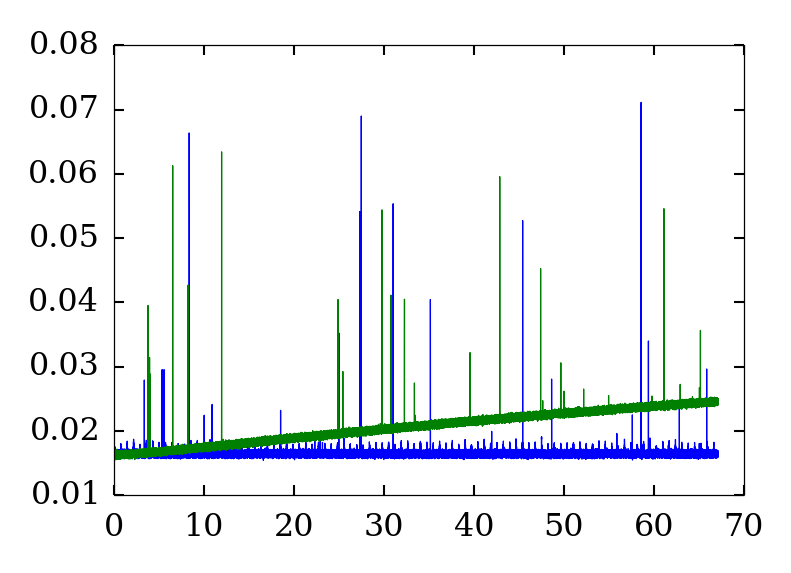

In [19]:
plt.plot(s1_on.epoch - s1_on.epoch.min(), abs(s1_on.s21))
plt.plot(s1_off.epoch - s1_off.epoch.min(), abs(s1_off.s21))

In [20]:
s1_on = sweep_from_rnc(rnc, on_index, 1)

In [21]:
s1_off = sweep_from_rnc(rnc, off_index, 1)

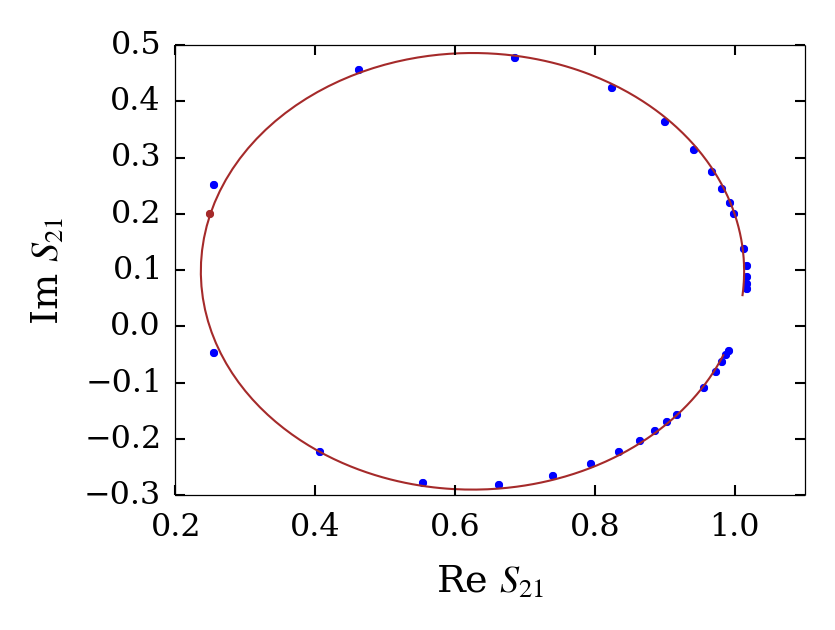

In [22]:
plot_resonator.IQ_circle(s1_on.resonator, normalize_s21=True);

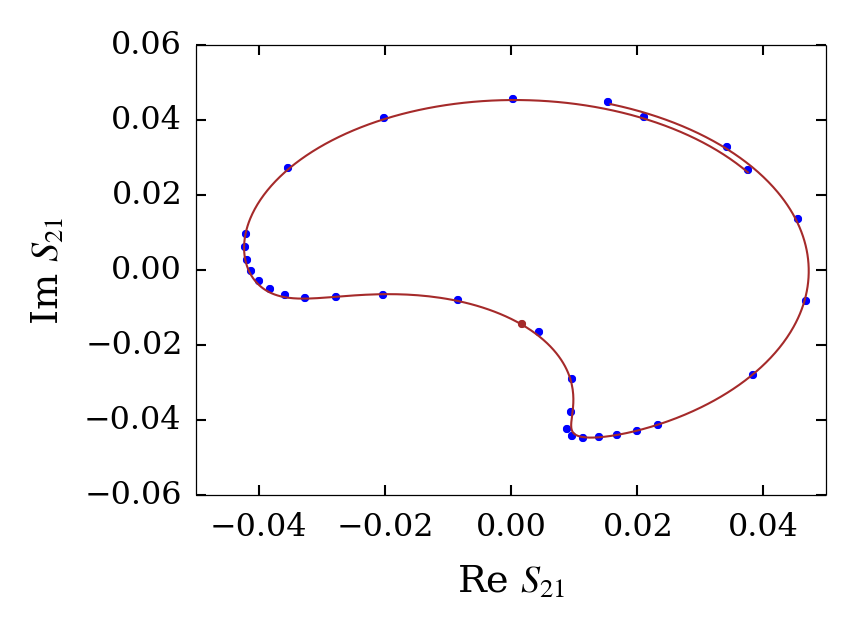

In [23]:
plot_resonator.IQ_circle(s1_off.resonator, normalize_s21=False);

In [24]:
ss_channel = 0
ss_on = sweepstream_from_rnc(rnc, sweep_index=on_index, stream_index=on_index, channel=ss_channel)
ss_off = sweepstream_from_rnc(rnc, sweep_index=off_index, stream_index=off_index, channel=ss_channel)

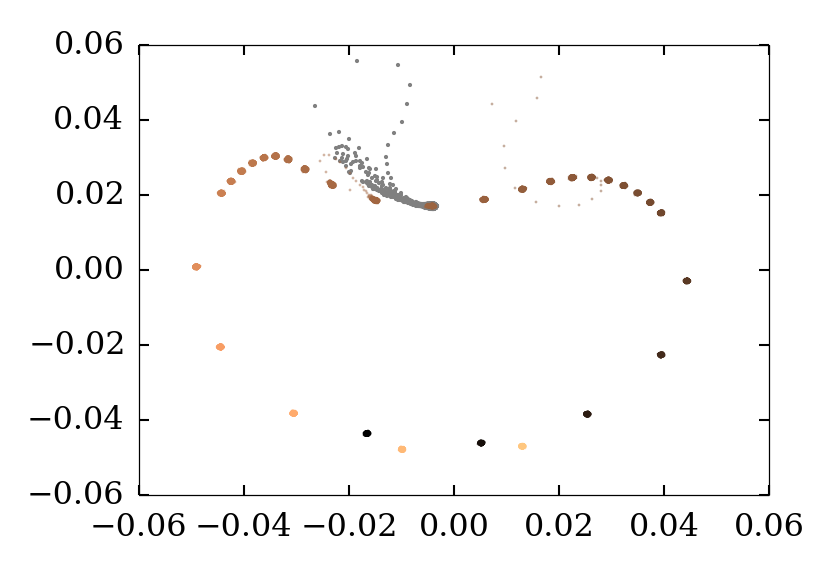

In [25]:
mappable = plt.cm.ScalarMappable(matplotlib.colors.Normalize(min(ss_on.sweep.frequency), max(ss_on.sweep.frequency)), cmap=plt.cm.copper)
mappable.set_array(ss_on.sweep.frequency)
fig, ax = plt.subplots()
ax.plot(ss_on.stream.s21.real, ss_on.stream.s21.imag, '.', color='gray', ms=1)
for s in ss_on.sweep.streams:
    ax.plot(s.s21.real, s.s21.imag, '.', color=mappable.to_rgba(s.frequency), ms=0.2)

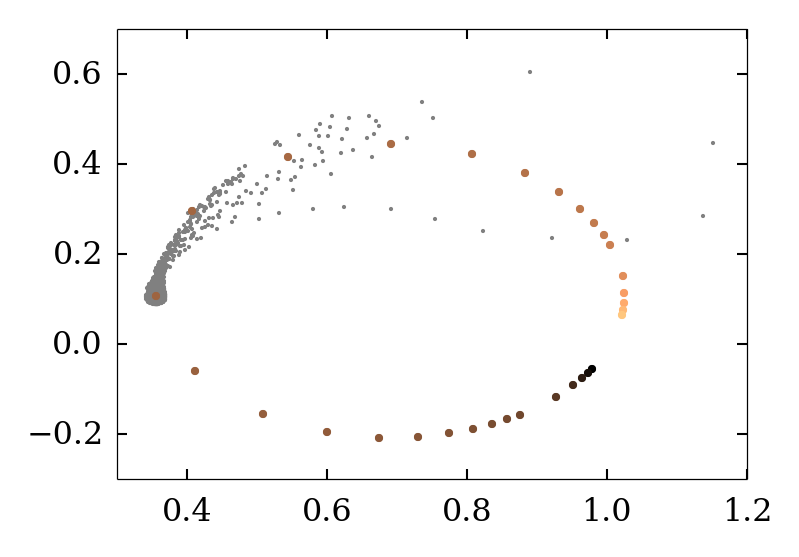

In [26]:
fig, ax = plt.subplots()
ax.plot(ss_on.stream_s21_normalized.real, ss_on.stream_s21_normalized.imag, '.', color='gray', ms=1)
for s21n, f in zip(ss_on.sweep_s21_normalized, ss_on.sweep.frequency):
    ax.plot(s21n.real, s21n.imag, '.', color=mappable.to_rgba(f))

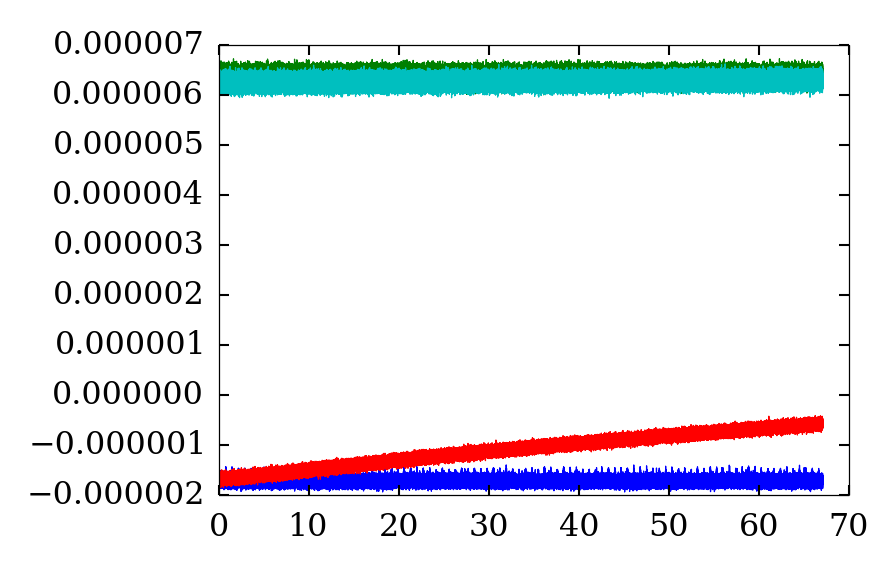

In [27]:
plt.plot(ss_on.stream.epoch - ss_on.stream.epoch.min(), ss_on.x)
plt.plot(ss_on.stream.epoch - ss_on.stream.epoch.min(), ss_on.i)
plt.plot(ss_off.stream.epoch - ss_off.stream.epoch.min(), ss_off.x)
plt.plot(ss_off.stream.epoch - ss_off.stream.epoch.min(), ss_off.i)

In [28]:
ss_on._set_psd_i_and_x(detrend=plt.mlab.detrend_linear)
ss_off._set_psd_i_and_x(detrend=plt.mlab.detrend_linear)

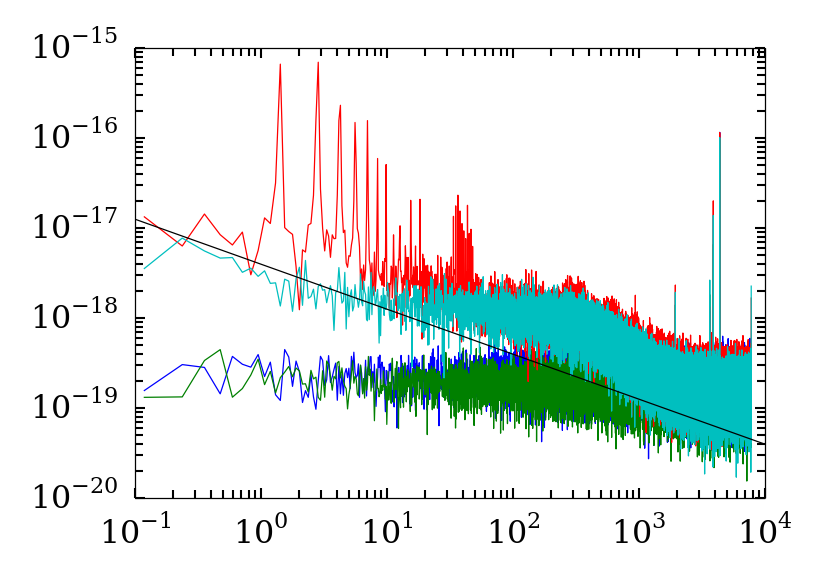

In [29]:
plt.loglog(ss_on.psd_frequency[1:], ss_on.psd_ii[1:] / 4)
plt.loglog(ss_off.psd_frequency[1:], ss_off.psd_ii[1:] / 4)
plt.loglog(ss_on.psd_frequency[1:], ss_on.psd_xx[1:])
plt.loglog(ss_off.psd_frequency[1:], ss_off.psd_xx[1:])
ff = np.logspace(-1, 4, 1e3)
plt.loglog(ff, 0.4e-17 * ff**(-1/2), '-k')

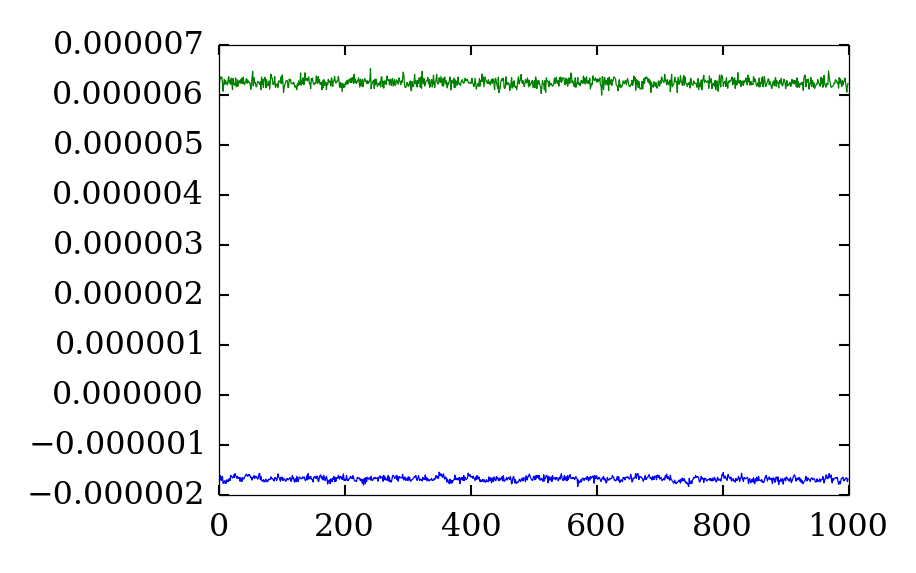

In [30]:
plt.plot(ss_off.x[:1e3])
plt.plot(ss_off.i[:1e3])

In [170]:
reload(nc)

<module 'kid_readout.measure.nc' from '/home/flanigan/kid_readout.git/kid_readout/measure/nc.py'>

In [32]:
ss_on.state['string'] = 'Hello, world!'
ss_on.state['number'] = 5.3
ss_on.state['sequence'] = (3, 3)

In [33]:
df = nc.DataFile('/home/flanigan/data/test.nc')

In [34]:
df.save_measurement(ss_on, name='SweepStream_on')
df.save_measurement(ss_off, name='SweepStream_off')

In [35]:
df.measurements

OrderedDict([('SweepStream_on', <netCDF4.Group object at 0x46a67d0>), ('SweepStream_off', <netCDF4.Group object at 0x46a6150>)])

In [37]:
df.dataset.close()
df = nc.DataFile('/home/flanigan/data/test.nc')

In [42]:
ssl = measurement.SweepStream().from_group(df.measurements['SweepStream_on'])

In [48]:
ssl.state['number']

5.2999999999999998

In [49]:
ssl.state['string']

u'Hello, world!'

In [47]:
ssl.state['sequence']

array([3, 3])

In [50]:
rnc.hardware_state_epoch

array([  1.43137103e+09,   1.43137129e+09,   1.43137147e+09,
         1.43137156e+09,   1.43137185e+09])